# Snakes and Ladders Markov Chain Model

This Notebook demostrates the use of a Markov Chain to model statistically a game of Snakes and Ladders.

**Snakes and Ladders Rules**

- The game is played on a 10x10 board with sequentially numbered squares starting from 1 at the bottom left corner and snaking right to left/left to right until reaching square 100 at the top left.
- There are a large number of variations but most have 8-10 ladders and 8-10 snakes (or "chutes" in American versions).
- The game is played by moving a counter (for each player) sequentially across the board according to the throw of a single, six-sided die
- If at the end of a throw, the counter lands on a square occupied by the bottom of a ladder, the counter is moved immediately to the square containing the top of the ladder.
- If at the end of a throw, the counter lands on a square occupied by the head of a snake (or top of a chute), the counter is moved immediately to the square containing the tail of the snake (or bottom of the chute).
- The game is won by the first player to reach the end of the board.

**Variations**
- Exact finish: in this variation, the player must land exactly on square 100 in order to finish the game. If the player throws a longer move than what is left to square 100, he/she foregoes the move.
- Re-throw on 6: in this variation, when a player throws a 6, he moves the counter and then immediately throws again. The player re-throws every time he/she gets a 6.

In [11]:
library(markovchain)
library(igraph)
library(jpeg)

Here we define our board. The board we are considering here is the one shown in the image below.

<img src="files/snakesnLadders3.jpg" width="400px">

We define the position of the snakes and ladders as the coordinates of each of their ends and define lists to index them easily.

In [12]:
# Define the positions of our ladders and snakes
ladderBottoms <- c( 1,  4,  9, 21, 28, 51, 72, 80, 110)
ladderTops <-    c(38, 14, 31, 42, 84, 67, 91, 99, 110)

laddersByBottom <- list()
laddersByTop <- list()
for (i in seq(1, length(ladderBottoms))){ 
  laddersByBottom[[ ladderBottoms[i] ]] <- ladderTops[i]
  laddersByTop[[ ladderTops[i] ]] <- ladderBottoms[i]
}

snakeHeads <- c(17, 62, 87, 54, 64, 93, 95, 98, 110) 
snakeTails <- c( 7, 19, 36, 34, 60, 73, 75, 79, 110) 

snakesByHead <- list()
snakesByTail <- list()
for (i in seq(1, length(snakeHeads))){ 
  snakesByHead[[ snakeHeads[i] ]] <- snakeTails[i]
  snakesByTail[[ snakeTails[i] ]] <- snakeHeads[i]
}

 This function is taken from the demo code for the markovchain package at https://github.com/spedygiorgio/markovchain
 
 
 It is used to return the components of a canonic form transition matrix



In [13]:
# +---+---+
# | Q | R |
# |---|---|
# | 0 | I | 
# +---+---+
# 
# Q = transitional states, R = Absorbing states
# 
# 0 = zero matrix, I = identity matrix
#  
# N = Funcdamental matrix = (I - Q)^-1 = Q.Q.Q...
# 
# NR = Final absorbtion probabilities
extractMatrices <- function(mcObj) {
  require(matlab)
  mcObj <- canonicForm(object = mcObj)
  #get the indices of transient and absorbing
  transIdx <- which(states(mcObj) %in% transientStates(mcObj))
  absIdx <- which(states(mcObj) %in% absorbingStates(mcObj))
  #get the Q, R and I matrices
  Q <- as.matrix(mcObj@transitionMatrix[transIdx,transIdx])
  R <- as.matrix(mcObj@transitionMatrix[transIdx,absIdx])
  I <- as.matrix(mcObj@transitionMatrix[absIdx, absIdx])
  #get the fundamental matrix
  N <- solve(eye(size(Q)) - Q)
  #computing final absorbion probabilities
  NR <- N %*% R
  #return
  out <- list(
    canonicalForm = mcObj,
    Q = Q,
    R = R,
    I = I,
    N=N,
    NR=NR
  )
  return(out)
}

**PropagateProps**: Propagate the probabilities for an initial state threw the transition table.

 **Parameters**:
- **transitionMatrix** : the matrix of transition probabilities forming the Markov Chain.
- **state**: The initial state from which the probabilities to other states have to be computed.
- **stateOffset**: Used only if re-rolling on 6 is enabled (see doubleRollOn6). If subsequent rolls are required propagateProps is called recursively using stateOffset to indicate where the re-roll occurred.
- **totalProb**: The total probability (0-1.0) that is to be distributed amongst the transitional states. Can be less than 1.0 on re-rolls.
- **finishExect**: Boolean flag indicating whether an exact roll onto square 100 is required to win the game.   
- **doubleRollOn6**: Boolean flag indicating that the player should take another roll every time he rolls a 6.

In [14]:
propagateProps <- function(transitionMatrix, state, stateOffset, totalProb, finishExact, doubleRollOn6){
  # Terminating condition
  if (state>nrow(transitionMatrix)) {
    return (transitionMatrix)
  }
  
  # Decide from where to start counting
  stateBase = state+stateOffset
  
  # Check if we are at a ladder bottom or snake head - if we are move immedately to the ladder top or the snake tail
  if (state>1){
    if ( (state-1) %in% ladderBottoms ){
      ladderTop <- laddersByBottom[[state-1]]
      transitionMatrix[state, ladderTop+1] <- totalProb
      return (transitionMatrix)
    }
    if ( (state-1) %in% snakeHeads ){
      snakeTail <- snakesByHead[[state-1]]
      transitionMatrix[state, snakeTail+1] <- totalProb
      return (transitionMatrix)
    }  
  }
  
  # Go through the 6 possible dice roll outcomes
  for (j in seq(1, 6)){
    destState<-0
    destProb<-0
    
    # Check if the roll took us to a ladder bottom or a snake head
    # totalProb/6 is the probability to be distributed 
    if ((stateBase+j-1) %in% ladderBottoms){
      ladderTop <- laddersByBottom[[stateBase+j-1]]
      destState <- ladderTop+1
      destProb <- (totalProb/6)
    } else if ((stateBase+j-1) %in% snakeHeads) {
      snakeTail <- snakesByHead[[stateBase+j-1]]
      destState <- snakeTail+1
      destProb <- (totalProb/6)
    }
    else { 
      destState <- stateBase+j
      destProb <- totalProb/6
    }
    
    # Have we gone beyond the end of the board?
    if (destState > nrow(transitionMatrix)){
      if (finishExact) {
        # We need an exact roll to win
        transitionMatrix[state, stateBase] = transitionMatrix[state, stateBase] + destProb
      } else {
        # We don't need an exact roll
        transitionMatrix[state, nrow(transitionMatrix)] <- transitionMatrix[state, nrow(transitionMatrix)] + destProb
      }
    }
    else {
      if ((j==6) && doubleRollOn6){
        # Handle double-rolls by calling ourselves recursively
        transitionMatrix <- propagateProps(transitionMatrix, state, destState-state, destProb, finishExact, doubleRollOn6)
      } else {
        transitionMatrix[state, destState] <- transitionMatrix[state, destState] + destProb
      }
    }
  }
  
  return(transitionMatrix)
}
  

**constructTransitionMatrix**: Construct a transition matrix for a game of Snakes and Ladders taking into account the positons of the snakes/ladders as well as the selected game variation.

**Parameters**:
- **finishExact**: Boolean flag indicating that an exact roll onto square 100 is required to win the game
- **doubleRollOn6**: Boolean flag indicating that a player has to roll again upon rolling a 6

In [15]:
constructTransitionMatrix <- function(finishExact, doubleRollOn6) {
  transitionMatrix <- matrix(data=rep(0, 101*101), nrow=101, ncol=101, byrow=TRUE)
  
  # build the matrix row by tow
  for (i in seq(1, 101)){
    transitionMatrix <- propagateProps(transitionMatrix, i, 0, 1.0, finishExact, doubleRollOn6)
  }
  
  return(transitionMatrix)
}

Set up a matrix encoding possible gameplay variations. 

The matrix contains all combinations of "exact finish" and "re-roll on 6". 

Also set up a variable to select the required variation. The value of the variable should be the row number in the matrix that contains the settings for the required variation.

In [16]:
paramMatrix = matrix(c(FALSE, FALSE, FALSE, TRUE, TRUE, FALSE, TRUE, TRUE), byrow=TRUE, ncol=2)

selected.variation=3

This cell contains the code for the main process. It uses the **selected.variation** variable along with **paramMatrix** to decide the game variation to use.

In [17]:
finishExact <- paramMatrix[selected.variation,1]
doubleRollOn6 <- paramMatrix[selected.variation ,2]

# Set up some visualisation- and filename-related labels depending on the variation.
subTitle <- ""
fNameSuffix <- ""
if (finishExact) {
subTitle <- paste(sep="", subTitle, "Exact finish")
fNameSuffix <- paste(sep="", fNameSuffix, "_exact")
} else {
subTitle <- paste(sep="", subTitle, "Non-exact finish")
fNameSuffix <- paste(sep="", fNameSuffix, "_onexact")
}

if (doubleRollOn6) {
subTitle <- paste(sep="", subTitle, ", re-roll on 6")
fNameSuffix <- paste(fNameSuffix, "_reroll")
} else {
subTitle <- paste(sep="", subTitle, ", no re-roll on 6")
fNameSuffix <- paste(sep="", fNameSuffix, "_noreroll")  
}

First thing is to generate a transition table. A transition table is a 101x101 cell matrix. Every cell (i,j) in the matrix is the probability of going from state *i* to state *j*, that is the probability of moving from square *i* to square *j*. 

Each line *i* of the matrix distributes the total probability of 1.0 across the possible subsequent states *j* according to the possible throws, the positions of the snakes and ladders and the game variation.

In [18]:
cat("\nCalculating probabilities for: ", subTitle, "\n")
transitionMatrix <- constructTransitionMatrix(finishExact, doubleRollOn6)


Calculating probabilities for:  Exact finish, no re-roll on 6 


Initialise a MarkovChain object (from the MarkovChain package) with our transition matrix. This package helps simplify some of the operations dealing with Markov Chains.

Extract the component matrices of our transition matrix (in canonical form). The most important matrix returned by this function is the **fundamental matrix**.

The fundamental matrix is equivalent to multiplying the matrix Q of transitional states by itself to infinity. Every cell (i,j) in the fundamental matrix contains the expected number of times state j is visited starting from state i before being absorbed into an absorbing state (square 100 in our case, which corresponds to state 101 since we need an initial off-the-board state and since R indexes its vectors/matrices starting from 1)

In [19]:
# Initialise a MarkovChain object with our transition matrix
mcSNL <- new("markovchain", transitionMatrix = transitionMatrix, name = "SnakesNLadders") 

# Extract the matrix components and fundamental matrix
mats <- extractMatrices(mcSNL)

The ith row of the fundamental matrix contains the expected number of visits to every other state starting from i, therefore the first row contains the expected number of visits to every square on the board starting from the initial state. 

We plot the expected number of visits per square in a single game. Interesting to note the dips corresponding to the ladder bottoms and snake heads (14 in all).

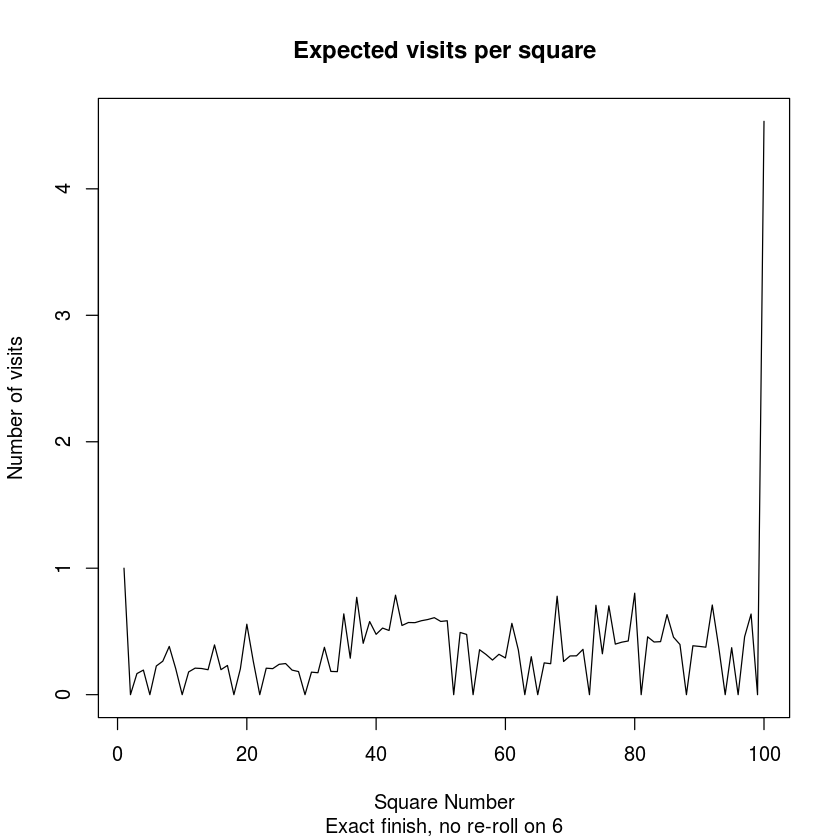

In [20]:
expected.visits = mats$N[1, ]

plot(1:length(expected.visits), expected.visits, type="l", main="Expected visits per square", sub=subTitle, xlab="Square Number", ylab="Number of visits")

Summing up the first row of the fundamental matrix gives us the expected number of moves in an average game since we would be summing the expected number of visits for every square on the board starting from the initial state.

We perform the summing up by multiplying  the fundamental matrix by a vector of 101 1's and taing the first element (length of game starting at initial state).

In [21]:
One = matrix(rep(1, 100))

# Average number of moves to win
# Every element (i,j) of the fundamental matrix N is the expected number of times that
# state j is visited started from state i, therefore summing over j gives the expected
# game length starting at each state i. 
avgMovesToWin <- (mats$N %*% One)[1]
cat("Mean number of moves to win (",subTitle,"): ", avgMovesToWin, "\n")


Mean number of moves to win ( Exact finish, no re-roll on 6 ):  38.09812 


In order to calculate the probability of a state i from a state i-1 we multiply the probability vector corresponding to state i-1 by the transition matrix giving a probability vector for state i. 

We define an initial probability vector having probability 1.0 of being in state 1 (off the board) and 0 everywhere else and we use it to calculate:

- the probability of having won in N moves
- the probability of winning on the Nth move

We plot both probabilities.

We also calculate:
- The median number of moves to win a game. This is calculated by taking the closest entry to a probability of 0.5 in the cumulative distribution (0.5 on the y-axis on the first graph).
- The modal number of moves to win a game. This is the move with the highest probability of winning the game (the peak in the second graph).

Median number of moves to win: ( Exact finish, no re-roll on 6 )  32 
Modal number of moves to win: ( Exact finish, no re-roll on 6 )  25 


png 
  2

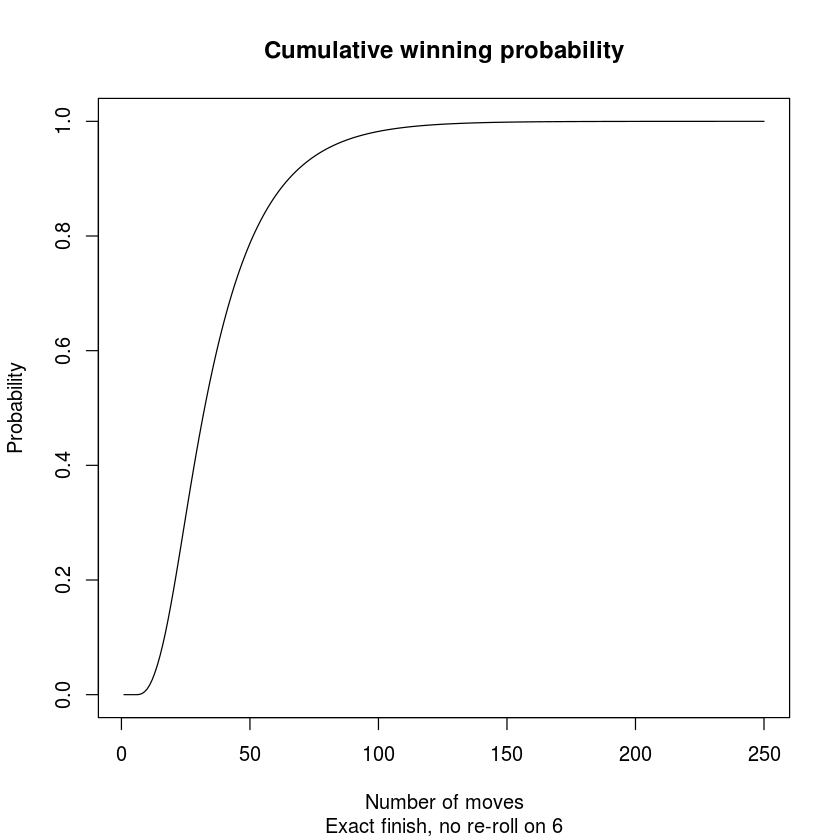

png 
  2

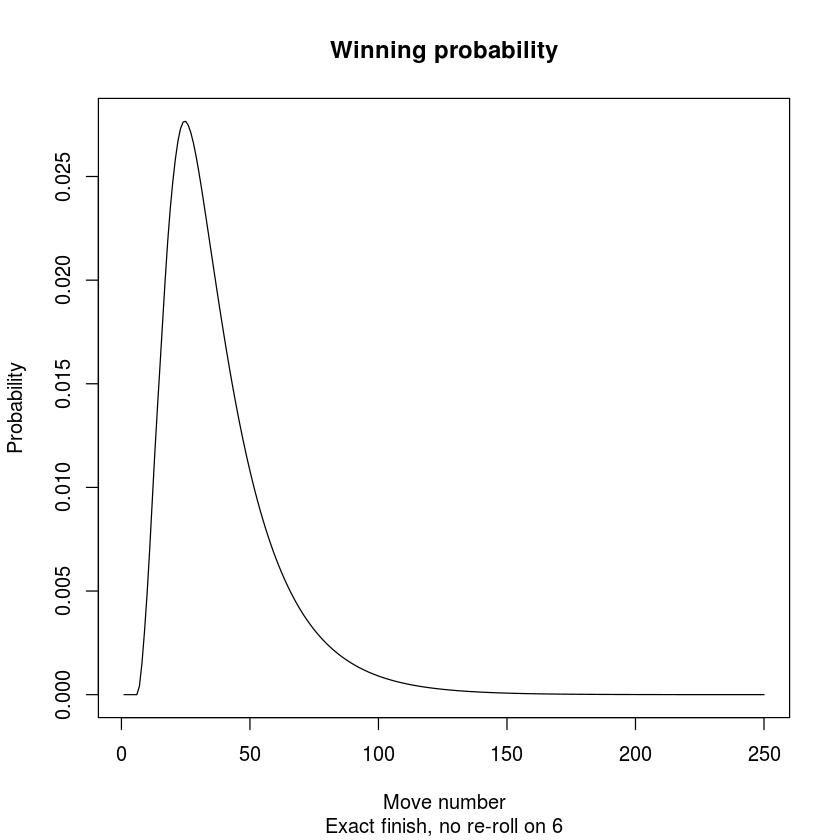

In [25]:
# Calculate the probability of winning vs. number of moves
# The vector of probabilities at the starting state
initProb <- rep(0, 101)
initProb[1] <- 1

havingWonProbs=c() # probability of having won after n moves
winInNProbs=c() # Probability of winning on the nth move

# Acuumulate the transition matrix probabilties saving the probability of
# having reached the ending state
maxMoves <- 250
cumul = initProb
for (k in seq(1, maxMoves)){
cumul <- cumul * mcSNL

#probs <- initProb * cumul

havingWonProbs <- c(havingWonProbs, cumul[101])
if (k>1){
  # The probability of winning on the kth move is the probability of having won on the kth - probability of having one on the k-1th move
  winInNProbs <- c(winInNProbs, cumul[101]-havingWonProbs[k-1])
} else {
  winInNProbs <- c(0)
}
}

medianMovesToWin <- which.min(abs(havingWonProbs-0.5))
cat("Median number of moves to win: (",subTitle,") ", medianMovesToWin, "\n")

modalMovesToWin <- which.max(winInNProbs)
cat("Modal number of moves to win: (",subTitle,") ", modalMovesToWin, "\n")

# Plot the probability of having won after N moves
plot(seq(1,maxMoves), havingWonProbs, type="l", main="Cumulative winning probability", xlab="Number of moves", ylab="Probability", sub=subTitle)
pdf(file = paste(sep="", "cumul_prob", fNameSuffix, ".pdf"))
plot(seq(1,maxMoves), havingWonProbs, type="l", main="Cumulative winning probability", xlab="Number of moves", ylab="Probability", sub=subTitle)
dev.off()

# Plot the probability of winning in N moves
plot(seq(1,maxMoves), c(0, diff(havingWonProbs)), type="l", main="Winning probability", xlab="Move number", ylab="Probability", sub=subTitle)
pdf(file = paste(sep="", "win_prob", fNameSuffix, ".pdf"))
plot(seq(1,maxMoves), c(0, diff(havingWonProbs)), type="l", main="Winning probability", xlab="Move number", ylab="Probability", sub=subTitle)
dev.off()

Here we determine the shortest possible game given the board layout and the game variation and we plot the moves overlayed on the board.

We define various functions to help us do this.

In order to get the shortest path to win the game, we construct a vertex graph using the transition matrix as an adjacency matrix using the iGraph package. We then use the iGraph get.shortest.paths() function to get the shortest possible path through the board.

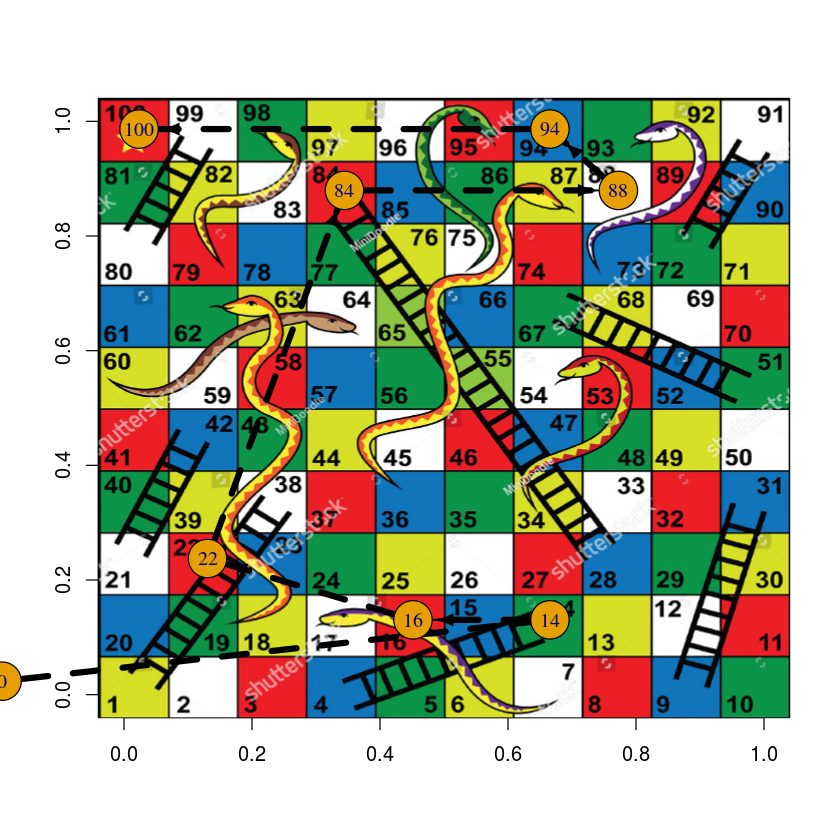

In [30]:
# reverse even rows so as to make matrix scan left/right like the Snakes and Ladders board.
adjustStateMatrix <- function(stateMat){
    rowsToReverse = seq(2, 10, 2)

    for (row in rowsToReverse){
      stateMat[row,] <- rev(stateMat[row,])
    }

    return(stateMat)
}

# Given a list of vertices, transform them into a list of vertex-to-vertex edges.
edgematrix.from.vertexlist <- function(vlist){
    emat <- matrix()
    for (vndx in 2:length(vlist)){
      e <- matrix(c(vlist[vndx-1], vlist[vndx]), ncol=2)

      if (ncol(emat)<2){
        emat <- e
      } else {
        emat <- rbind(emat, e)
      }
}

return(emat)
}
 
# Given a list of vertices (i.e. states, i.e. squares on the board), 
# return the coordinates of the square centres on the board to help us
# plot the moves overlayed on the board graphic.
coords.from.vertexlist <- function(vlist, origx, origy, width, height){
    coords <- matrix()

    boxwidth <- width/10
    boxheight <- height/10

    for (vndx in 1:length(vlist)){
      if (vlist[vndx]<=0){
        col = -2
        row = 0
      } else {
        col <- ((vlist[vndx]-1) %% 10)
        row <- ((vlist[vndx]-1) %/% 10)
      }

      # calc center of box
      vc <- (boxheight * row) + (boxheight/2)
      hc <- (boxwidth * col) + (boxwidth/2)

      # Reverse for even rows
      if ((row+1) %% 2 == 0){
        hc <- width-hc
      }      

      vc <- vc + origy
      hc <- hc + origx

      if (ncol(coords) < 2){
        coords <- matrix(c(hc, vc), ncol=2)
      } else {
        coords <- rbind(coords, matrix(c(hc, vc), ncol=2))
      }
    }

    return(coords)
}

options(warn=-1) # disable warnings

# Use transition matrix as adjacency matrix for iGraph 
snlgraph <- graph_from_adjacency_matrix(transitionMatrix>0, mode="directed")

# Extract the shortest path through the graph, which is also the shortest game
shortest.path.to.win <- (get.shortest.paths(snlgraph, from=1, mode="out")$vpath[[101]]-1)

# Transform the list squares to a list of moves i.e. graph edges.
shortest.path.edges <- apply(edgematrix.from.vertexlist(shortest.path.to.win), MARGIN=2, as.character)

# Get the coordinates of each square. This will be used to plot the graph representing the moves in the
# shortest game overlayed onto the board graphic.
shortest.path.coords <- coords.from.vertexlist(shortest.path.to.win, -0.03, -0.03, 1.07, 1.07)

# Load the board graphic
anImage <- readJPEG("snakesnLadders3.jpg")

# Set up a plot area with no plot
plot(x=0:1, y=0:1, type='n', main="", xlab="", ylab="")
par.old <- par() # save the graphics parameters
par(mar=rep(0,4)) # disable margins

# Get the plot information so the image will fill the plot box, and draw it
lim <- par()
rasterImage(anImage, lim$usr[1], lim$usr[3], lim$usr[2], lim$usr[4])

# Create a graph from the shortest game edges...
sg <- graph_from_edgelist(shortest.path.edges, directed = TRUE)

# ... and plot it.
plot(sg, layout=shortest.path.coords, edge.curved=FALSE, edge.width=5, edge.lty=2, edge.color="black", arrow.width=5, vertex.size=6,  add=TRUE, rescale=FALSE, asp=0, xlim=c(0,1), ylim=c(0,1), margin=c(0,0,0,0), xlab="", ylab="")

par(par.old) # restore graphical parameters
options(warn=0) # reenable warnings